# 10. Online continual learning

In machine learning, continual learning is a problem setting where a model is trained on a sequence of tasks and must perform well on all tasks seen so far. A task is a specific concept or relation the model expects to learn. Online continual learning adds the constraints that the model considers each example exactly once, and the model can perform prediction at any time.

In contrast to continual learning, the typical data stream problem setting adapts to changes in data distribution by discarding knowledge of the past. However, in continual learning, the model must retain knowledge of past tasks while learning new tasks.

Continual learning is synonymous with overcoming catastrophic forgetting, a phenomenon in deep learning where a model trained on a sequence of tasks forgets how to perform well on the initial tasks. Non-deep learning models can be immune to forgetting.

---

In this notebook, we implement “Experience Replay” (ER), a classic online continual learning strategy that stores a buffer of past examples. By sampling from the buffer during training, ER avoids catastrophic forgetting.

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last updated on 28/11/2025**

In [12]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

## 10.1 Reservoir sampling

Experience Replay uses [reservoir sampling](https://en.wikipedia.org/wiki/Reservoir_sampling) to construct a simple random sample incrementally from a data stream of unknown length. Here, we implement reservoir sampling "Algorithm R" (Vitter, 1985).

- Jeffrey S. Vitter. 1985. Random sampling with a reservoir. ACM Trans. Math. Softw. 11, 1 (March 1985), 37–57. https://doi.org/10.1145/3147.3165

In [13]:
import torch
from typing import Tuple
from torch import Tensor


class ReservoirSampler:
    def __init__(self, item_count: int, feature_count: int):
        self.item_count = item_count
        self.feature_count = feature_count
        self.reservoir_x = torch.zeros((item_count, feature_count))
        self.reservoir_y = torch.zeros((item_count,), dtype=torch.long)
        self.count = 0

    def update(self, x: Tensor, y: Tensor) -> None:
        batch_size = x.shape[0]
        assert x.shape == (
            batch_size,
            self.feature_count,
        )
        assert y.shape == (batch_size,)

        for i in range(batch_size):
            if self.count < self.item_count:
                # Fill the reservoir
                self.reservoir_x[self.count] = x[i]
                self.reservoir_y[self.count] = y[i]
            else:
                # Reservoir sampling
                index = torch.randint(0, self.count + 1, (1,))
                if index < self.item_count:
                    self.reservoir_x[index] = x[i]
                    self.reservoir_y[index] = y[i]
            self.count += 1

    def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
        indices = torch.randint(0, min(self.count, self.item_count), (n,))
        return self.reservoir_x[indices], self.reservoir_y[indices]

Let's check to see if it's samples look uniform.

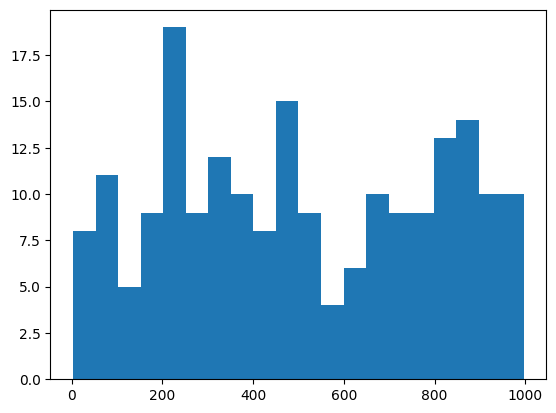

In [14]:
from matplotlib import pyplot as plt

x = torch.arange(0, 1_000).reshape(-1, 1).float()
y = torch.zeros(1_000, dtype=torch.long)
sampler = ReservoirSampler(500, 1)
sampler.update(x, y)
x = sampler.sample_n(200)
plt.hist(x[0].numpy(), bins=20)
plt.show()

## 10.2 Experience Replay


In [15]:
from capymoa.base import BatchClassifier
from capymoa.stream import Schema
from torch.nn.functional import cross_entropy
import numpy as np
from torch import nn


class ExperienceReplay(BatchClassifier):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        reservoir_size: int,
        learning_rate: float,
        device: str = "cpu",
    ):
        super().__init__(schema=schema)
        self.reservoir = ReservoirSampler(reservoir_size, schema.get_num_attributes())
        self.optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.device = torch.device(device)
        self.model = model.to(self.device)

    def batch_train(self, x: Tensor, y: Tensor):
        batch_size = x.shape[0]

        self.reservoir.update(x, y)

        replay_x, replay_y = self.reservoir.sample_n(batch_size)
        train_x = torch.cat((x, replay_x), dim=0).to(self.device)
        train_y = torch.cat((y, replay_y), dim=0).to(self.device)

        self.optimiser.zero_grad()
        y_hat = self.model(train_x)
        loss = cross_entropy(y_hat, train_y)
        loss.backward()
        self.optimiser.step()

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        y_hat: Tensor = self.model.forward(x)
        return y_hat.softmax(dim=1)

    def __str__(self) -> str:
        return "ExperienceReplay"

## 10.3 Multi Layer Perceptron

We create a simple multi-layer perceptron (MLP) with a single hidden layer to demonstrate continual learning.

The output layer of a neural network is often problematic in continual learning because of the extreme and shifting class imbalance between tasks. Lesort et al. (2021) suggest mitigating this by using a variant of weight normalisation that parameterises the weights as a magnitude (set to the unit vector) and a direction. 

* Lesort, T., George, T., & Rish, I. (2021). Continual Learning in Deep Networks:
 An Analysis of the Last Layer.

In [25]:
class SimpleMLP(nn.Module):
    def __init__(self, schema: Schema, hidden_size: int):
        super().__init__()
        num_classes = schema.get_num_classes()

        self.fc1 = nn.Linear(schema.get_num_attributes(), hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=False)
        self.fc2 = nn.utils.parametrizations.weight_norm(self.fc2, name="weight")
        weight_g = self.fc2.parametrizations.weight.original0
        # Set the magnitude to the unit vector
        weight_g.requires_grad_(False).fill_(1.0 / (num_classes**0.5))

    def forward(self, x: Tensor) -> Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
from capymoa.ocl.evaluation import ocl_train_eval_loop
from capymoa.ocl.datasets import SplitMNIST

stream = SplitMNIST()
mlp = SimpleMLP(stream.schema, 64)
learner = ExperienceReplay(
    stream.schema,
    mlp,
    reservoir_size=200,
    learning_rate=0.01,
    device="cpu",
)
r = ocl_train_eval_loop(
    learner,
    stream.train_loaders(64),
    stream.test_loaders(64),
    progress_bar=True,
    continual_evaluations=4,
)
print(f"Forward Transfer  {r.forward_transfer:.2f}")
print(f"Backward Transfer {r.backward_transfer:.2f}")
print(f"Accuracy          {r.accuracy_final:.2f}")
print(f"Prequential Acc.  {r.ttt.cumulative.accuracy() / 100:.2f}")

Train & Eval:   0%|          | 0/4119 [00:00<?, ?it/s]

Forward Transfer  0.00
Backward Transfer -0.21
Accuracy          0.79
Prequential Acc.  0.90


## 10.4 Evaluation

The plot displays the model's accuracy across tasks. Task zero begins with high accuracy, which decreases as the model forgets. In contrast, tasks one through four start at zero accuracy since the model has not seen the task yet.

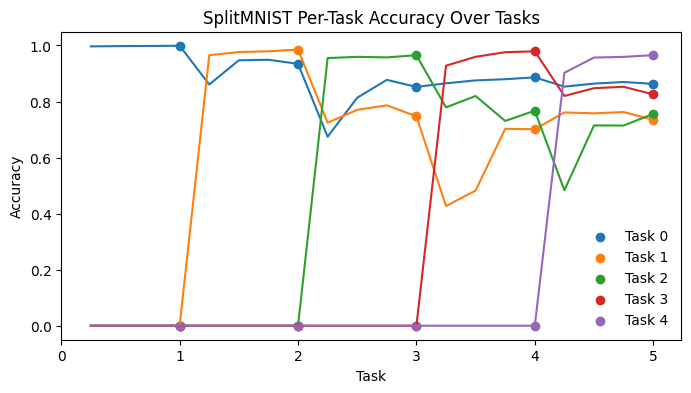

In [18]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

cmap = plt.get_cmap("tab10")
for t in range(5):
    ax.scatter(r.task_index, r.accuracy_matrix[:, t], color=cmap(t), label=f"Task {t}")
    ax.plot(r.anytime_task_index, r.anytime_accuracy_matrix[:, t], color=cmap(t))

ax.set_xlabel("Task")
ax.set_xticks(range(6))
ax.set_ylabel("Accuracy")
ax.set_title("SplitMNIST Per-Task Accuracy Over Tasks")
ax.legend(frameon=False)
pass

Here we plot some useful measures of accuracy for a continual learner.

* **Acc. (all)**
  
  This is the accuracy on all tasks including unseen ones after training completes on each task.

* **Acc. (seen)**
  
  This is the accuracy only on seen tasks after completing training on each task.

* **Anytime Acc. (all/seen)**

  Like "Acc. (all/seen)" but measured periodically during the training of each task.

* **Avg. Anytime Acc. (all/seen)**

  This is the average of "Anytime Acc. (all/seen)".

* **Online Win. Acc.**

  This is the usual data stream windowed test-then-train accuracy over the data stream.

* **Online Avg. Acc.**

  This is the usual cumulative test-then-train accuracy over the data stream.

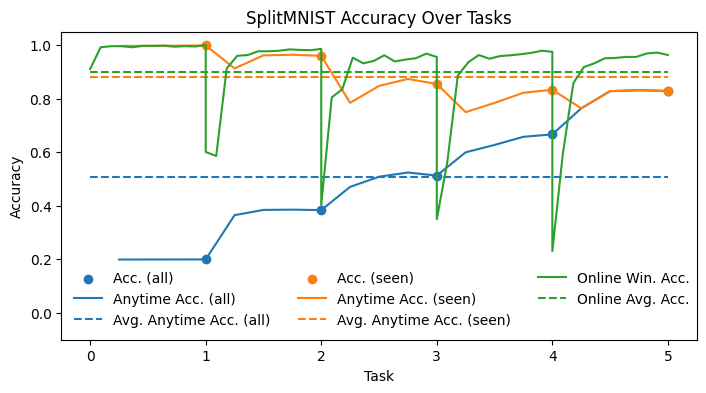

In [19]:
def hline(ax, y, label, color):
    ax.hlines(y, 0, 5, linestyles="--", label=label, color=color)


fig, ax = plt.subplots(figsize=(8.2, 4))
# Plot the accuracy on all tasks over the course of tasks
ax.scatter(r.task_index, r.accuracy_all, label="Acc. (all)")
ax.plot(r.anytime_task_index, r.anytime_accuracy_all, label="Anytime Acc. (all)")
hline(ax, r.anytime_accuracy_all_avg, "Avg. Anytime Acc. (all)", cmap(0))

# Plot the accuracy on previously seen tasks over the course of tasks
ax.scatter(r.task_index, r.accuracy_seen, label="Acc. (seen)")
ax.plot(r.anytime_task_index, r.anytime_accuracy_seen, label="Anytime Acc. (seen)")
hline(ax, r.anytime_accuracy_seen_avg, "Avg. Anytime Acc. (seen)", cmap(1))

# Windowed test-then-train accuracy
ax.plot(
    r.ttt_windowed_task_index,
    np.array(r.ttt.windowed.accuracy()) / 100,  # percentage to proportion
    label="Online Win. Acc.",
)
# Cumulative test-then-train accuracy
hline(ax, r.ttt.cumulative.accuracy() / 100, "Online Avg. Acc.", cmap(2))

ax.legend(ncol=3, frameon=False)
ax.set_xlabel("Task")
ax.set_xticks(range(6))
ax.set_ylabel("Accuracy")
ax.set_title("SplitMNIST Accuracy Over Tasks")
ax.set_ylim(-0.1, 1.05)
pass

You can use the usual prequential evaluation results object with `r.ttt` (short for test-then-train).

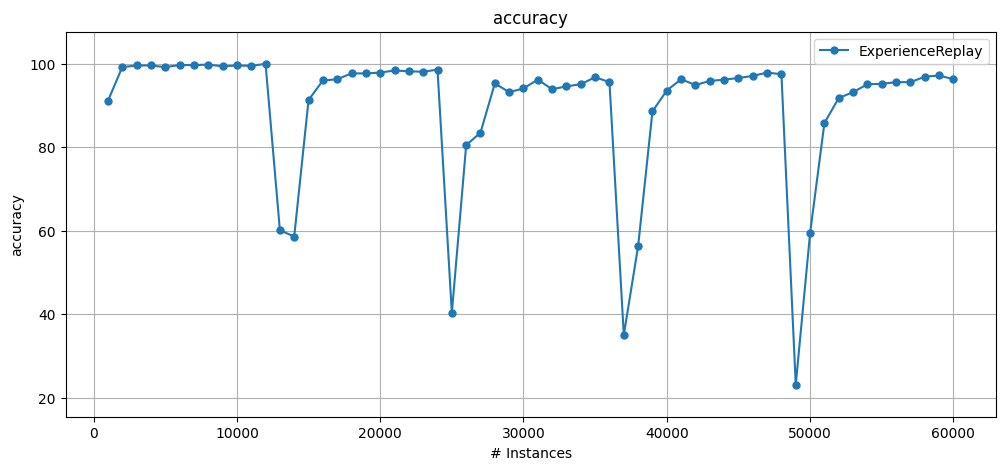

In [20]:
from capymoa.evaluation.visualization import plot_windowed_results

plot_windowed_results(r.ttt, metric="accuracy")